In [1]:
%load_ext autoreload
%autoreload 2

### Graph embedding notebook

This notebook uses the graph embedding module with improved model architecture:
- Enhanced TrainableGraphGINE with L2-normalized embeddings
- Improved projection head for contrastive learning
- Enhanced data augmentation with edge dropping

The notebook automatically loads the latest best checkpoint.

Evaluate options for graph embeddings

some useful references:

- https://distill.pub/2021/gnn-intro/
- https://web.stanford.edu/class/cs224w/
- https://pytorch-geometric.readthedocs.io/en/latest/

Structure of the nb:

1) data prep
2) model and training
3) visualization

Next steps:

Train/test split, include Argoverse data

In [2]:
import os
os.getcwd()
os.chdir("../..")

In [3]:
from torch_geometric.data import Data
import numpy as np
from enum import Enum

import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import DataLoader
from torch.utils.data import Subset

import torch
import torch.nn.functional as F
import os
import glob
from sklearn.model_selection import train_test_split

import pickle
from tqdm import tqdm

# Create module alias for pickle compatibility (old pickles reference 'graph_creator' without 'src.' prefix)
import sys
import src.graph_creator
sys.modules['graph_creator'] = src.graph_creator

from src.graph_creator.MapGraph import MapGraph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, HTML
import json
# Using graph embeddings module with improved model architecture
from src.graph_creator.graph_embeddings import GraphDataset, TrainableGraphGINE, contrastive_loss, augment_graph, get_feature_dimensions, networkx_to_pyg
from src.graph_creator.plot_graphs import MapVisualizer

### Data prep

In [4]:
#graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/*.pkl")
base_path= "/mnt/ssd_data/graph_coverage"
graph_setting = "graph_setting_1_50_50_10_20_20_4_4_4"
carla_graph_dir = f'actor_graphs/carla_actor_{graph_setting}'
argoverse_graph_dir = f'actor_graphs/argoverse_actor_{graph_setting}'

carla_graph_paths = glob.glob(f"{base_path}/{carla_graph_dir}_components_nx/*.pkl")
print(f"{base_path}/{carla_graph_dir}_components_nx")
print(len(carla_graph_paths))


/mnt/ssd_data/graph_coverage/actor_graphs/carla_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx
202371


In [5]:
carla_graph_paths[-1]

'/mnt/ssd_data/graph_coverage/actor_graphs/carla_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx/graph_2025-12-31 16:29:52.820188_Town05_9_8.pkl'

In [6]:
argoverse_graph_paths = glob.glob(f"{base_path}/{argoverse_graph_dir}_components_nx/*.pkl")
print(len(argoverse_graph_paths))
argoverse_graph_paths[-1]

284752


'/mnt/ssd_data/graph_coverage/actor_graphs/argoverse_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx/graph_ffff65e0-212b-4e75-9560-a48f56b4957c_9_0_0.pkl'

In [7]:
# add argoverse data
#argoverse_graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/*.pkl")
graph_paths = carla_graph_paths.copy()
graph_paths.extend(argoverse_graph_paths)
print(len(graph_paths))

# open one argoverse graph

# with open(argoverse_graph_paths[0], 'rb') as f:
#     graph = pickle.load(f)
# print(graph.nodes(data=True))
# graph.edges(data=True)

487123


In [8]:
print(graph_paths[0])
print(graph_paths[-1])
#argoverse_graph_paths[0]


/mnt/ssd_data/graph_coverage/actor_graphs/carla_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx/graph_2025-10-05 20:53:06.306761_Town01_0_0.pkl
/mnt/ssd_data/graph_coverage/actor_graphs/argoverse_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx/graph_ffff65e0-212b-4e75-9560-a48f56b4957c_9_0_0.pkl


### ML prep

In [ ]:
# Train/test split for graph_ds

# Load data
graph_ds = GraphDataset(graph_paths)

indices = np.arange(len(graph_ds))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)

train_ds = Subset(graph_ds, train_idx)
test_ds = Subset(graph_ds, test_idx)

# Create loaders (overrides earlier train_loader)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=16)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=16)

print(f"Train size: {len(train_ds)} | Test size: {len(test_ds)}")
data_loaders = {"train": train_loader, "test": test_loader}

# try out data loading
_item = graph_ds.__getitem__(4320)
_batch = next(iter(train_loader))

Train size: 389698 | Test size: 97425


/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
# next(iter(test_loader))


### Load the checkpoint

In [12]:
# Find the latest checkpoint directory and load the best model
checkpoint_base_dir = "/home/tmuehlen/repos/graph_coverage/checkpoints"

# Get all checkpoint directories sorted by name (timestamp format ensures chronological order)
checkpoint_dirs = sorted([d for d in os.listdir(checkpoint_base_dir) 
                          if os.path.isdir(os.path.join(checkpoint_base_dir, d))])

# Find the latest directory that has a best_model.pt file
latest_checkpoint_dir = None
for d in reversed(checkpoint_dirs):
    best_model_path = os.path.join(checkpoint_base_dir, d, "best_model.pt")
    if os.path.exists(best_model_path):
        latest_checkpoint_dir = d
        break

if latest_checkpoint_dir is None:
    raise FileNotFoundError("No checkpoint directory with best_model.pt found!")

checkpoint_path = os.path.join(checkpoint_base_dir, latest_checkpoint_dir)
config_path = os.path.join(checkpoint_path, "config.json")
best_model_path = os.path.join(checkpoint_path, "best_model.pt")

print(f"Using checkpoint directory: {latest_checkpoint_dir}")
print(f"Best model path: {best_model_path}")

# Load config
with open(config_path, 'r') as f:
    config = json.load(f)

# Extract model parameters (v2 uses embedding_dim instead of output_dim)
hidden_dim = config['model']['hidden_dim']
embedding_dim = config['model'].get('embedding_dim', config['model'].get('output_dim', 256))
num_layers = config['model']['num_layers']

print(f"\nModel configuration:")
print(f"  hidden_dim: {hidden_dim}")
print(f"  embedding_dim: {embedding_dim}")
print(f"  num_layers: {num_layers}")

Using checkpoint directory: 20260123_101713
Best model path: /home/tmuehlen/repos/graph_coverage/checkpoints/20260123_101713/best_model.pt

Model configuration:
  hidden_dim: 384
  embedding_dim: 192
  num_layers: 5


In [13]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
node_dim, edge_dim = get_feature_dimensions()

# v2 model uses embedding_dim parameter instead of separate hidden_dim and output_dim
model = TrainableGraphGINE(
    node_dim, 
    edge_dim, 
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim, 
    num_layers=num_layers
).to(device)

print(f"Model created with node_dim={node_dim}, edge_dim={edge_dim}")
print(f"Embedding dimension: {embedding_dim}")

Model created with node_dim=7, edge_dim=7
Embedding dimension: 192


In [14]:
# Load the best model checkpoint
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Display checkpoint info
print(f"Loaded checkpoint from: {best_model_path}")
if 'best_test_loss' in checkpoint:
    print(f"Best test loss: {checkpoint['best_test_loss']:.4f}")
if 'loop' in checkpoint and 'epoch' in checkpoint:
    print(f"From loop {checkpoint['loop']}, epoch {checkpoint['epoch']}")

Loaded checkpoint from: /home/tmuehlen/repos/graph_coverage/checkpoints/20260123_101713/best_model.pt
Best test loss: 0.0291
From loop 13, epoch 3


/tmp/ipykernel_753699/622228002.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


### Visualize the loss curves

In [15]:
# Read and parse the training log file
import re

log_path = os.path.join(checkpoint_path, "training.log")

train_losses = []
test_losses = []

with open(log_path, 'r') as f:
    for line in f:
        # Match lines containing "Current Losses - Train: X.XXXX, Test: X.XXXX"
        match = re.search(r'Current Losses - Train: ([\d.]+), Test: ([\d.]+)', line)
        if match:
            train_losses.append(float(match.group(1)))
            test_losses.append(float(match.group(2)))

# Create a DataFrame for easy plotting
loss_df = pd.DataFrame({
    'epoch': range(len(train_losses)),
    'train_loss': train_losses,
    'test_loss': test_losses
})

print(f"Loaded {len(train_losses)} loss values from training log")
print(f"Final train loss: {train_losses[-1]:.4f}, Final test loss: {test_losses[-1]:.4f}")
loss_df.head()

Loaded 60 loss values from training log
Final train loss: 0.0293, Final test loss: 0.0292


,epoch,train_loss,test_loss
0,0,0.2831,0.2842
1,1,0.2069,0.2085
2,2,0.1394,0.1406
3,3,0.1166,0.1172
4,4,0.1072,0.1101


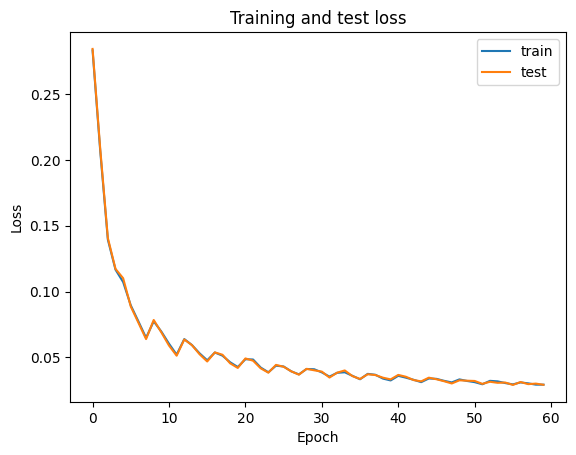

In [16]:
plt.plot(loss_df["train_loss"], label = "train")
plt.plot(loss_df["test_loss"], label = "test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.title("Training and test loss")
plt.savefig("/home/tmuehlen/repos/graph_coverage/article/plots/train_test_graph_embeddings_loss_plot.png")
plt.show()


### Inference on train and test

In [17]:
# Inference loop
model.eval()
all_embeddings = {"train": [], "test": []}
all_paths = {"train": [], "test": []}

for split in data_loaders:  
    with torch.no_grad():
        for batch in tqdm(data_loaders[split]):
            all_paths[split].extend(batch[1]) 
            batch = batch[0].to(device)
            outputs = model(batch)
            embeddings = outputs['embeddings']
            all_embeddings[split].append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = {}
for split in all_embeddings:
    final_embeddings[split] = torch.cat(all_embeddings[split], dim=0)

print(f'Extracted {final_embeddings["train"].shape[0]} embeddings of dimension {final_embeddings["train"].shape[1]}')

100%|██████████| 762/762 [00:44<00:00, 17.04it/s]


Extracted 389698 embeddings of dimension 192


### Visualization of embeddings

In [31]:
print(all_paths["train"][0])
all_paths["train"][0].split("/")[-2]

/mnt/ssd_data/graph_coverage/actor_graphs/argoverse_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx/graph_c78d8ad7-195a-455e-9d2c-937c48cef7bd_9_0_0.pkl


'argoverse_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx'

In [32]:
# some data preparation
#graph_dates_train = [path.split("/")[-1].split("_")[1] for path in all_paths["train"]]
#graph_dates_test = [path.split("/")[-1].split("_")[1] for path in all_paths["test"]]
#all_paths
#graph_dates = {"train": graph_dates_train, "test": graph_dates_test}

graph_type_train = [path.split("/")[-2].split("_")[0] for path in all_paths["train"]]
graph_type_test = [path.split("/")[-2].split("_")[0] for path in all_paths["test"]]
graph_type = {"train": graph_type_train, "test": graph_type_test}

# Convert embeddings to numpy
split = "test"
embeddings_np = final_embeddings[split].numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

dim_reduc_df = pd.DataFrame(pca_result)
dim_reduc_df.columns = ["pca1", "pca2"]
dim_reduc_df["graph_type"] = graph_type[split]
dim_reduc_df["graph_path"] = all_paths[split]
dim_reduc_df.head()

,pca1,pca2,graph_type,graph_path
0,0.020603,0.002289,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...
1,0.424893,-0.200782,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...
2,-0.439322,-0.022269,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...
3,0.388283,0.424101,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...
4,-0.333490,0.179888,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...


In [33]:
pd.Series(graph_type["test"]).value_counts()


argoverse    56978
carla        40447
Name: count, dtype: int64

In [34]:
# t-SNE
#tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter = 550, verbose = 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter = 250, verbose = 1)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["graph_type"] = graph_type[split]
tsne_df["graph_path"] = all_paths[split]
tsne_df.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 97425 samples in 0.008s...
[t-SNE] Computed neighbors for 97425 samples in 7.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 97425
[t-SNE] Computed conditional probabilities for sample 2000 / 97425
[t-SNE] Computed conditional probabilities for sample 3000 / 97425
[t-SNE] Computed conditional probabilities for sample 4000 / 97425
[t-SNE] Computed conditional probabilities for sample 5000 / 97425
[t-SNE] Computed conditional probabilities for sample 6000 / 97425
[t-SNE] Computed conditional probabilities for sample 7000 / 97425
[t-SNE] Computed conditional probabilities for sample 8000 / 97425
[t-SNE] Computed conditional probabilities for sample 9000 / 97425
[t-SNE] Computed conditional probabilities for sample 10000 / 97425
[t-SNE] Computed conditional probabilities for sample 11000 / 97425
[t-SNE] Computed conditional probabilities for sample 12000 / 97425
[t-SNE] Computed conditional probabilities for sam

,tsne1,tsne2,graph_type,graph_path
0,-0.173731,-0.529515,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...
1,1.086695,-1.190965,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...
2,-1.877838,-0.791286,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...
3,2.569543,1.600769,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...
4,-1.094565,0.474468,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...


In [35]:
dim_reduc_df["tsne1"] = tsne_df["tsne1"]
dim_reduc_df["tsne2"] = tsne_df["tsne2"]

In [36]:
dim_reduc_df.head(5)

,pca1,pca2,graph_type,graph_path,tsne1,tsne2
0,0.020603,0.002289,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.173731,-0.529515
1,0.424893,-0.200782,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...,1.086695,-1.190965
2,-0.439322,-0.022269,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-1.877838,-0.791286
3,0.388283,0.424101,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,2.569543,1.600769
4,-0.333490,0.179888,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...,-1.094565,0.474468


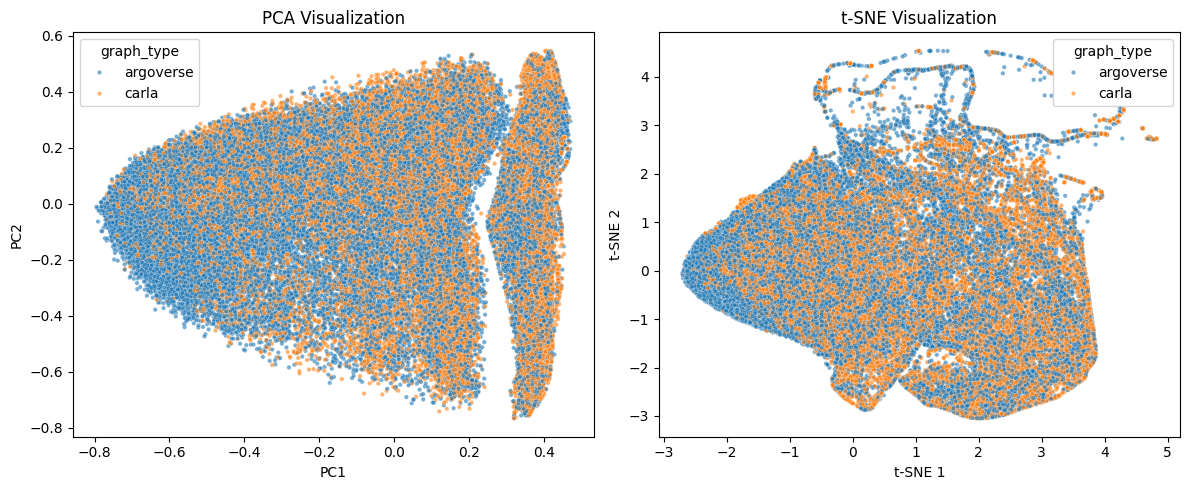

In [37]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# make the plot symbol smaller
sns.scatterplot(x="pca1", y="pca2", alpha=0.6, hue="graph_type", legend = True, data=dim_reduc_df, s = 10)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')


plt.subplot(1, 2, 2)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.6, hue="graph_type", legend = True, data=dim_reduc_df, s = 10)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_pca_tsne_{split}_plot.png")
plt.show()

### Interactive plots for manual cluster selection

In [38]:
# Create FigureWidget for interactive updates
fig_widget = go.FigureWidget()
pca_df_plot = dim_reduc_df.sample(50000).reset_index(drop=True)

# Add PCA scatter
fig_widget.add_scatter(
    x=pca_df_plot['pca1'],
    y=pca_df_plot['pca2'],
    mode='markers',
    marker=dict(
        size=6,
        color=pca_df_plot['graph_type'].map({'carla': 0, 'argoverse': 1}),
        colorscale='Viridis',
    ),
    text=pca_df_plot['graph_type'],
    hovertemplate='<b>Type:</b> %{text}<br><b>Index:</b> %{customdata}<br><b>PCA1:</b> %{x:.2f}<br><b>PCA2:</b> %{y:.2f}<extra></extra>',
    customdata=pca_df_plot.index,
    name='Graph Embeddings'
)

fig_widget.update_layout(
    title='Interactive PCA Plot - Select points to extract data',
    xaxis_title='PC1',
    yaxis_title='PC2',
    height=600,
    width=900,
    dragmode='lasso',
    hovermode='closest'
)

# Store selected data globally
selected_df = pd.DataFrame()

def selection_fn(trace, points, selector):
    """Callback function when points are selected"""
    global selected_df
    if len(points.point_inds) > 0:
        selected_indices = [pca_df_plot.index[i] for i in points.point_inds]
        selected_df = pca_df_plot.loc[selected_indices].copy()
        print(f"\n✓ Selected {len(selected_df)} points")
        print(f"Graph types: {selected_df['graph_type'].value_counts().to_dict()}")
        print(f"\nAccess selected data via: selected_df")
        display(selected_df.head())
    else:
        print("No points selected")

# Attach callback
fig_widget.data[0].on_selection(selection_fn)

# Display the widget
display(HTML("<h3>Use lasso or box select tool to select points</h3>"))
fig_widget


FigureWidget({
    'data': [{'customdata': {'bdata': ('AAAAAAEAAAACAAAAAwAAAAQAAAAFAA' ... 'AAS8MAAEzDAABNwwAATsMAAE/DAAA='),
                             'dtype': 'i4'},
              'hovertemplate': ('<b>Type:</b> %{text}<br><b>Ind' ... '2:</b> %{y:.2f}<extra></extra>'),
              'marker': {'color': {'bdata': ('AQEBAQEBAQABAQAAAAAAAQAAAQABAQ' ... 'EBAQABAAABAAABAAEAAQEBAQEBAQA='),
                                   'dtype': 'i1'},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        

,pca1,pca2,graph_type,graph_path,tsne1,tsne2
275,-0.462700,0.222051,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-1.901448,0.780425
635,-0.459193,0.237646,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-1.968233,0.734287
681,-0.536035,0.255746,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-2.166671,0.242692
795,-0.437891,0.192968,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-1.424475,-0.244898
995,-0.472986,0.188674,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...,-1.417082,-0.228338


In [39]:
# Interactive t-SNE plot
fig_widget_tsne = go.FigureWidget()
tsne_df_plot = dim_reduc_df.sample(50000).reset_index(drop=True)
# Add t-SNE scatter
fig_widget_tsne.add_scatter(
    x=tsne_df_plot['tsne1'],
    y=tsne_df_plot['tsne2'],
    mode='markers',
    marker=dict(
        size=6,
        color=tsne_df_plot['graph_type'].map({'carla': 0, 'argoverse': 1}),
        colorscale='Viridis',
    ),
    text=tsne_df_plot['graph_type'],
    hovertemplate='<b>Type:</b> %{text}<br><b>Index:</b> %{customdata}<br><b>t-SNE1:</b> %{x:.2f}<br><b>t-SNE2:</b> %{y:.2f}<extra></extra>',
    customdata=tsne_df_plot.index,
    name='Graph Embeddings'
)

fig_widget_tsne.update_layout(
    title='Interactive t-SNE Plot - Select points to extract data',
    xaxis_title='t-SNE 1',
    yaxis_title='t-SNE 2',
    height=600,
    width=900,
    dragmode='lasso',
    hovermode='closest'
)

# Store selected data globally
selected_tsne_df = pd.DataFrame()

def selection_fn_tsne(trace, points, selector):
    """Callback function when points are selected"""
    global selected_tsne_df
    if len(points.point_inds) > 0:
        selected_indices = [tsne_df_plot.index[i] for i in points.point_inds]
        selected_tsne_df = tsne_df_plot.loc[selected_indices].copy()
        print(f"\n✓ Selected {len(selected_tsne_df)} points")
        print(f"Graph types: {selected_tsne_df['graph_type'].value_counts().to_dict()}")
        print(f"\nAccess selected data via: selected_tsne_df")
        display(selected_tsne_df.head())
    else:
        print("No points selected")

# Attach callback
fig_widget_tsne.data[0].on_selection(selection_fn_tsne)

# Display the widget
display(HTML("<h3>Use lasso or box select tool to select points</h3>"))
fig_widget_tsne


FigureWidget({
    'data': [{'customdata': {'bdata': ('AAAAAAEAAAACAAAAAwAAAAQAAAAFAA' ... 'AAS8MAAEzDAABNwwAATsMAAE/DAAA='),
                             'dtype': 'i4'},
              'hovertemplate': ('<b>Type:</b> %{text}<br><b>Ind' ... '2:</b> %{y:.2f}<extra></extra>'),
              'marker': {'color': {'bdata': ('AQEBAAEAAQEAAAEBAAABAQAAAQEAAA' ... 'EAAQAAAQEAAAEAAAEBAQEBAQABAQE='),
                                   'dtype': 'i1'},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                                        

,pca1,pca2,graph_type,graph_path,tsne1,tsne2
1,0.170935,-0.394273,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.372576,-1.215529
71,-0.041191,-0.048916,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.467074,-1.392710
139,-0.107027,-0.082641,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.441841,-1.068023
144,0.039382,-0.592041,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.457457,-1.154520
146,-0.281733,-0.234858,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.884365,-0.898829


In [40]:
selected_tsne_df

,pca1,pca2,graph_type,graph_path,tsne1,tsne2
1,0.170935,-0.394273,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.372576,-1.215529
71,-0.041191,-0.048916,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.467074,-1.392710
139,-0.107027,-0.082641,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.441841,-1.068023
144,0.039382,-0.592041,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.457457,-1.154520
146,-0.281733,-0.234858,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.884365,-0.898829
...,...,...,...,...,...,...
49814,-0.323663,-0.128538,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.934776,-1.042436
49821,-0.242639,-0.341207,argoverse,/mnt/ssd_data/graph_coverage/actor_graphs/argo...,-0.659856,-0.865571
49838,0.038873,-0.457500,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...,-0.480282,-1.108242
49884,-0.159700,0.142571,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...,-0.697212,-1.481753


In [41]:
# data prep for doing graph plots
os.getcwd()
#os.chdir("../..")
#os.getcwd()

dim_reduc_emb_df = pd.concat([dim_reduc_df, pd.DataFrame(embeddings_np)], axis = 1)
dim_reduc_emb_df.head(2)

mask_carla = dim_reduc_df.graph_type == "carla"
mask_argo = dim_reduc_df.graph_type == "argoverse"
dim_reduc_carla_df = dim_reduc_df[mask_carla].reset_index(drop=True)
dim_reduc_argo_df = dim_reduc_df[mask_argo].reset_index(drop=True)

print(sum(mask_carla), sum(mask_argo))
dim_reduc_carla_df.head(2)

40447 56978


,pca1,pca2,graph_type,graph_path,tsne1,tsne2
0,0.424893,-0.200782,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...,1.086695,-1.190965
1,-0.333490,0.179888,carla,/mnt/ssd_data/graph_coverage/actor_graphs/carl...,-1.094565,0.474468


# visualizing examples from one cluster selection

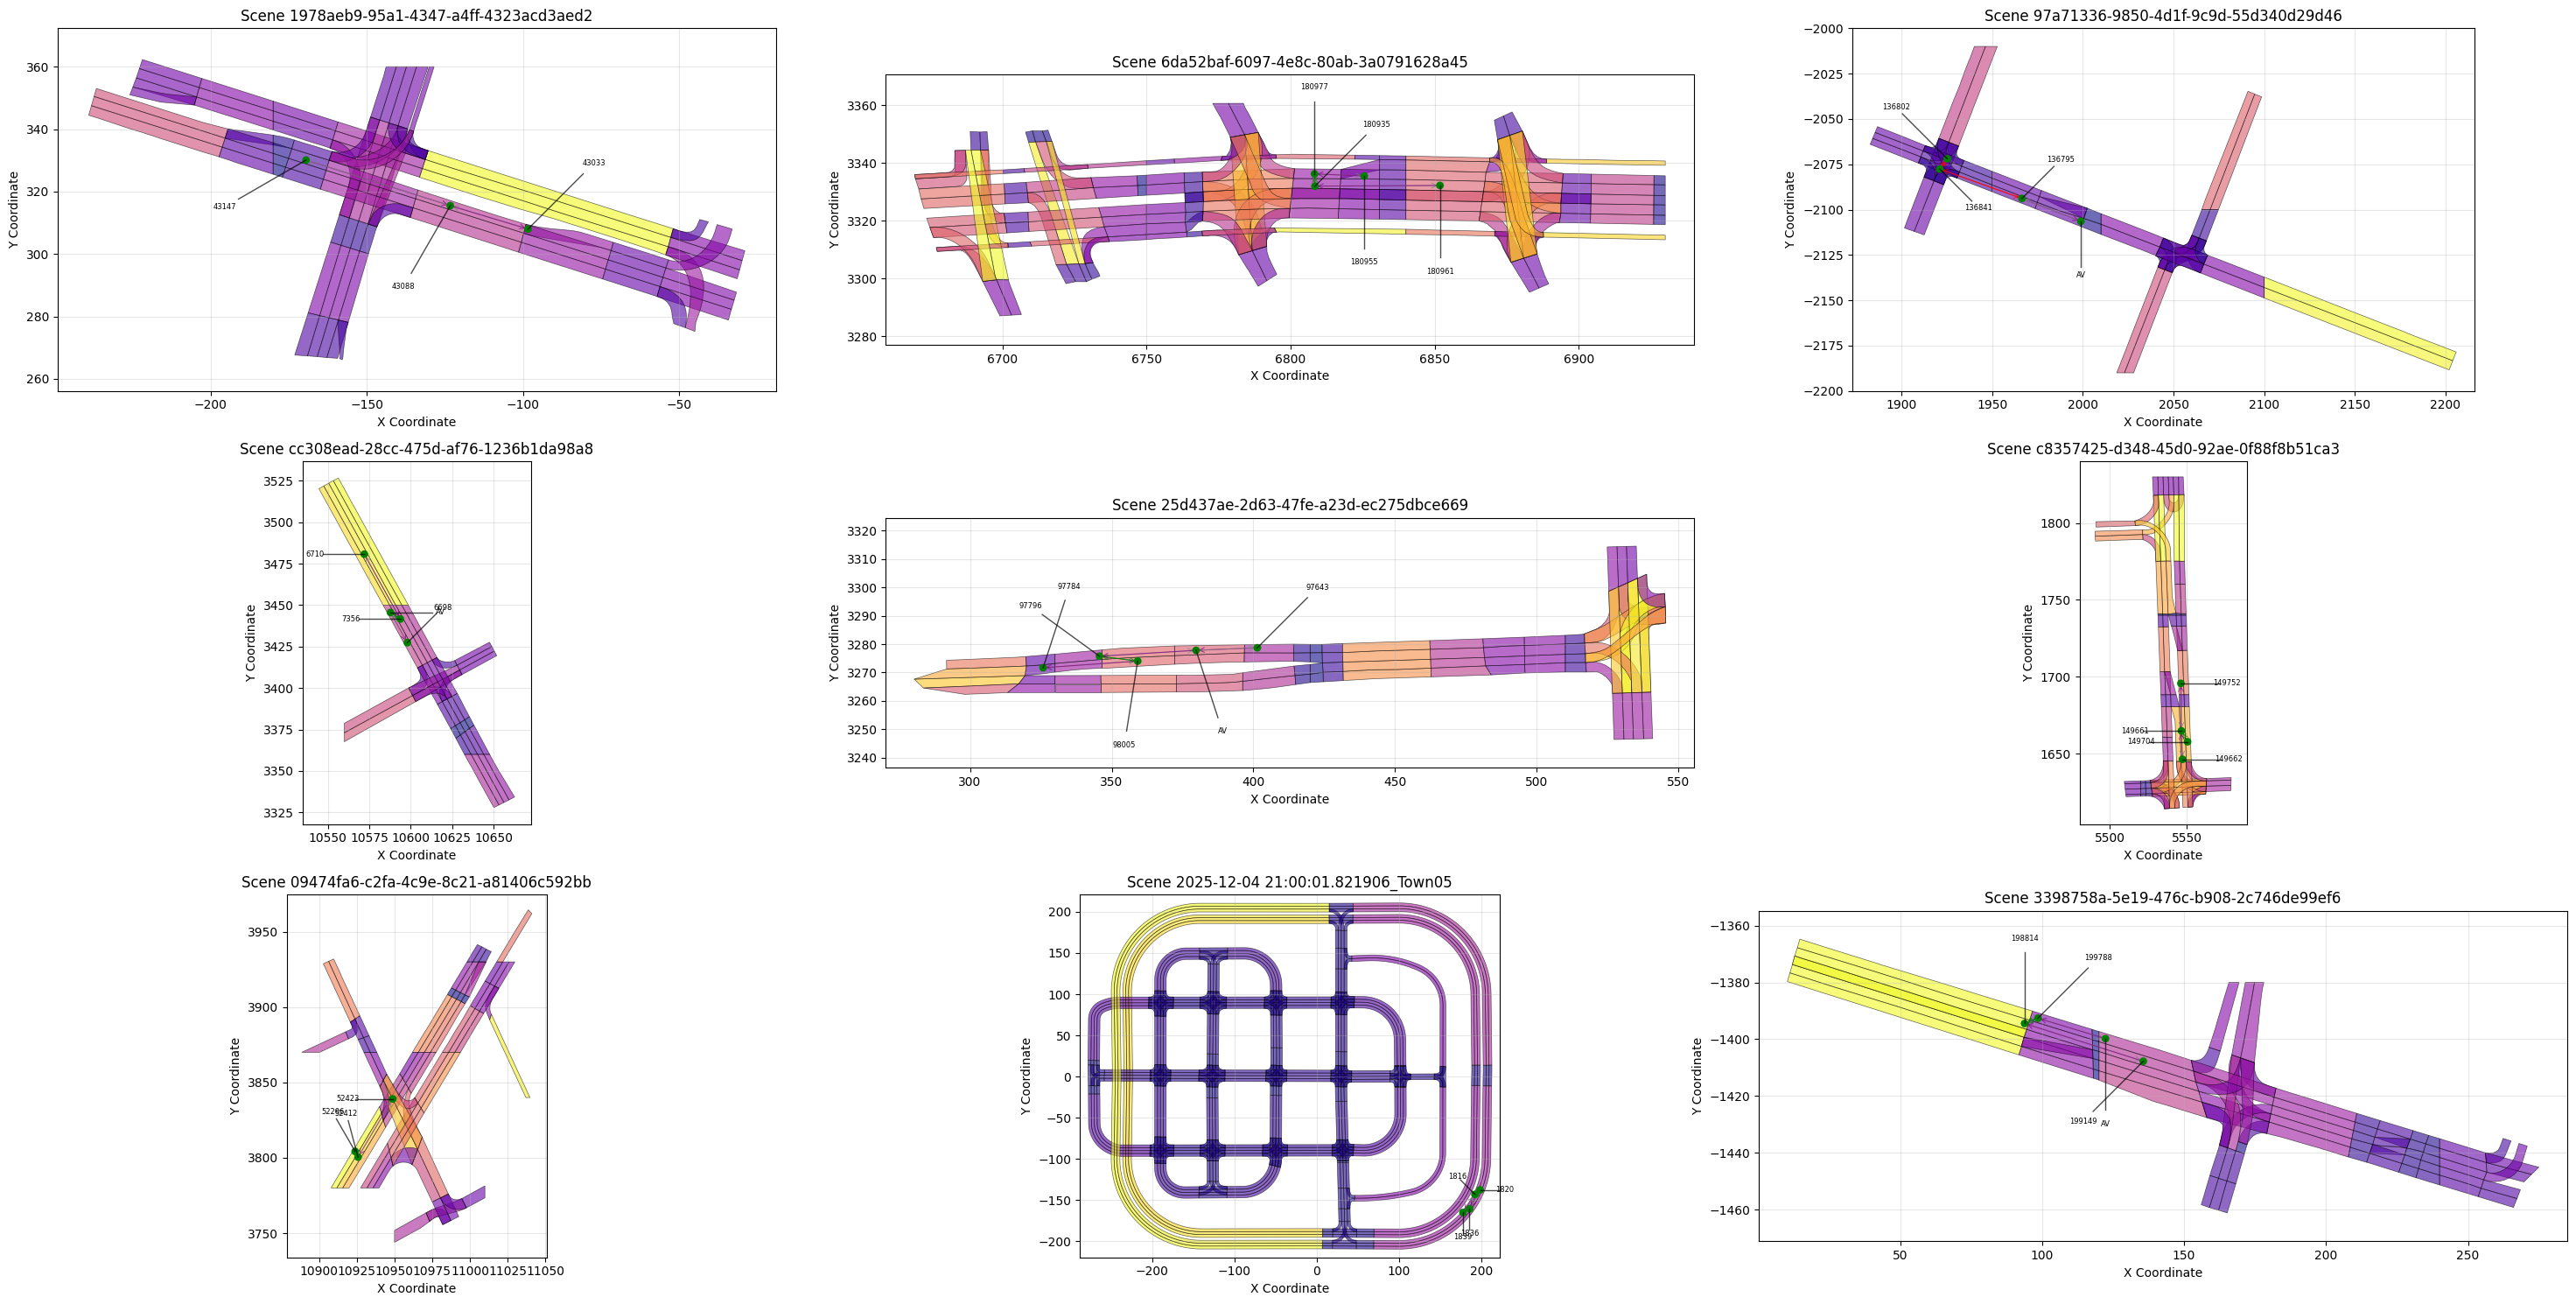

In [43]:
# visualizing examples from one cluster selection
fig, axes = plt.subplots(3, 3, figsize=(30, 15))
axes = axes.flatten()  # Flatten to easily index with loop counter

for i in range(9):
    if selected_tsne_df.graph_type.iloc[i] == "carla":
        graph = selected_tsne_df.graph_path.iloc[i].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn = "_".join(graph.split("_")[:2])
        file_path = f"/home/tmuehlen/repos/graph_coverage/{carla_graph_dir}_components_nx/graph_{graph}.pkl"
        with open(file_path, 'rb') as f:
            nx_graph = pickle.load(f)
        g_map = MapGraph()
        # g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn}_map_graph.pickle')
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/{carla_graph_dir}/{scn}_map_graph.pkl')
        g_map = g_map.graph.graph
    else:
        # argoverse option
        graph = selected_tsne_df.graph_path.iloc[i].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn = graph[:36]
        file_path = f"/home/tmuehlen/repos/graph_coverage/{argoverse_graph_dir}_components_nx/graph_{graph}.pkl"
        with open(file_path, 'rb') as f:
            nx_graph = pickle.load(f)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/{argoverse_graph_dir}/{scn}_map_graph.pkl')
        g_map = g_map.graph.graph
    # Create figure with two subplots side by side
    ax = axes[i]

    MapVisualizer(fig=fig, ax=ax) \
        .add_lanes(g_map, color_by_length=True, cmap='plasma', show_labels=False) \
        .add_actors(nx_graph, actor_size=20) \
        .add_actor_labels() \
        .add_actor_edges(nx_graph) \
        .set_title(f'Scene {scn}')
    # fig, ax = plot_lane_map_advanced(g_map, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax)
    # fig, ax = add_actors_to_map(fig, ax, nx_graph, actor_size=20, show_actor_labels=False)
    # fig, ax = add_actor_edges_to_map(fig, ax, nx_graph)
    # ax.set_title(f'Scene {scn}')
# Adjust layout and display
plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_cluster_examples.png")
plt.show()

### Comparing closest embeddings:

In [44]:
carla_graph_dir

'actor_graphs/carla_actor_graph_setting_1_50_50_10_20_20_4_4_4'

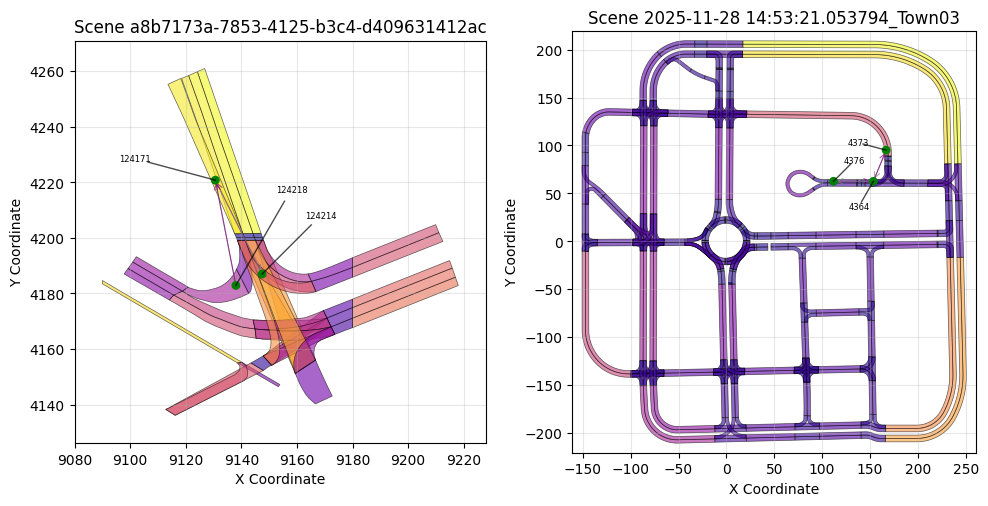

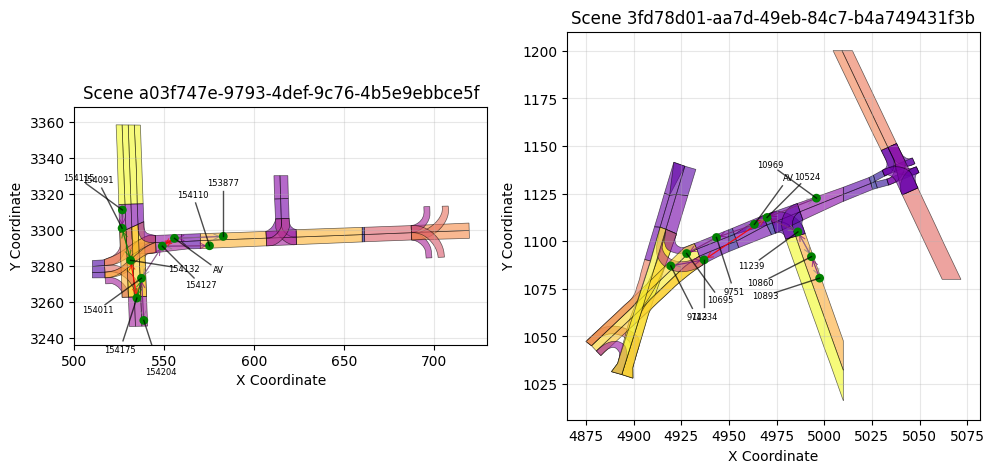

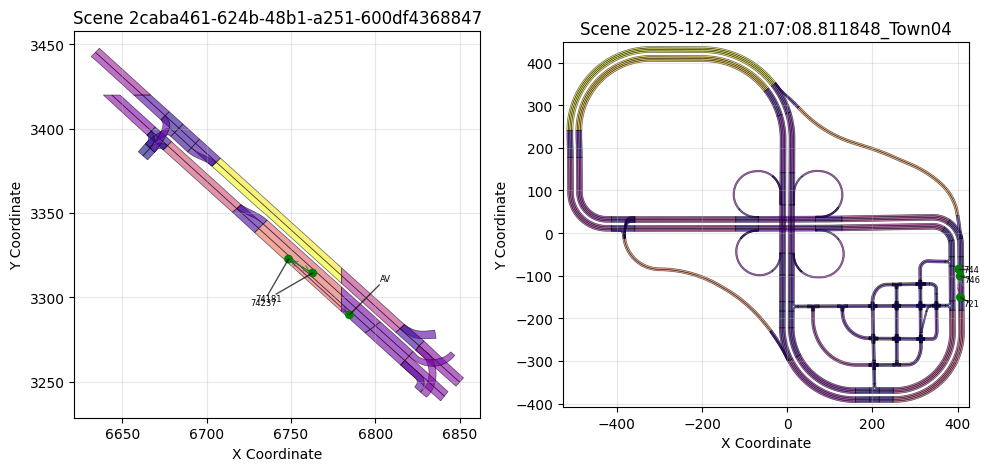

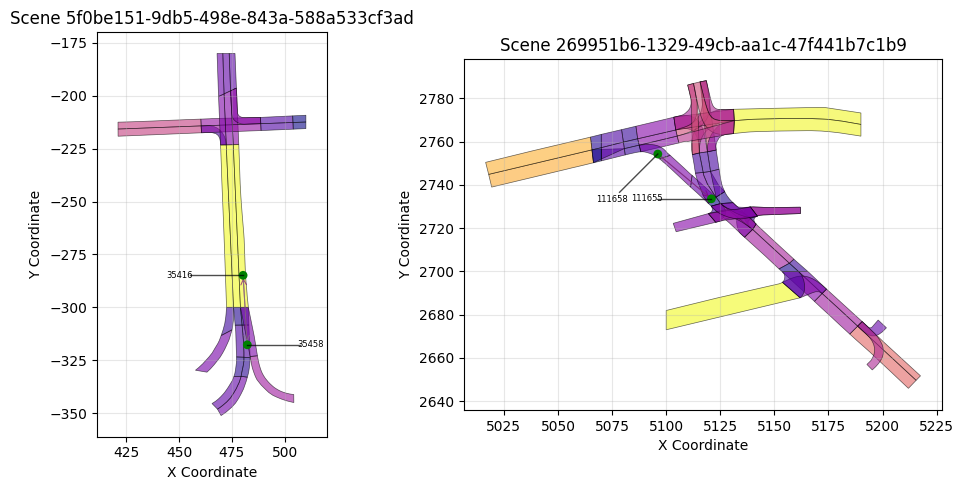

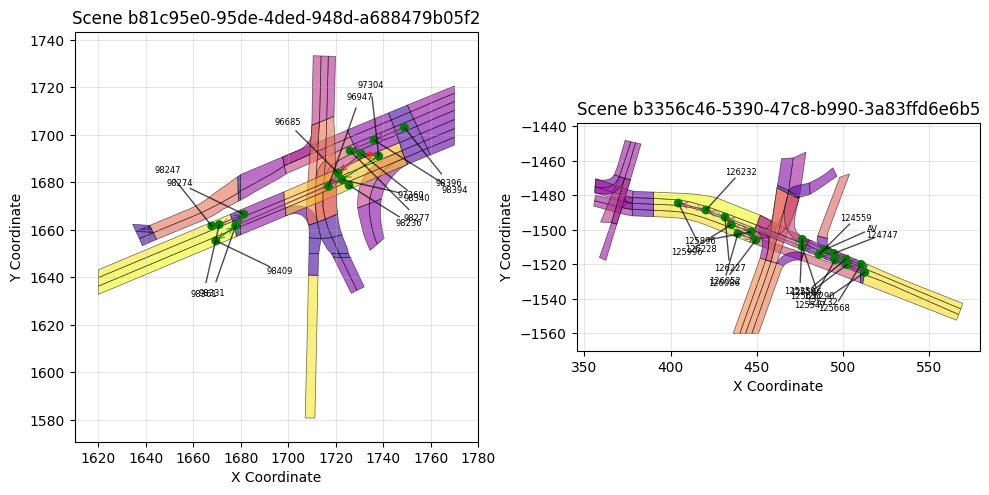

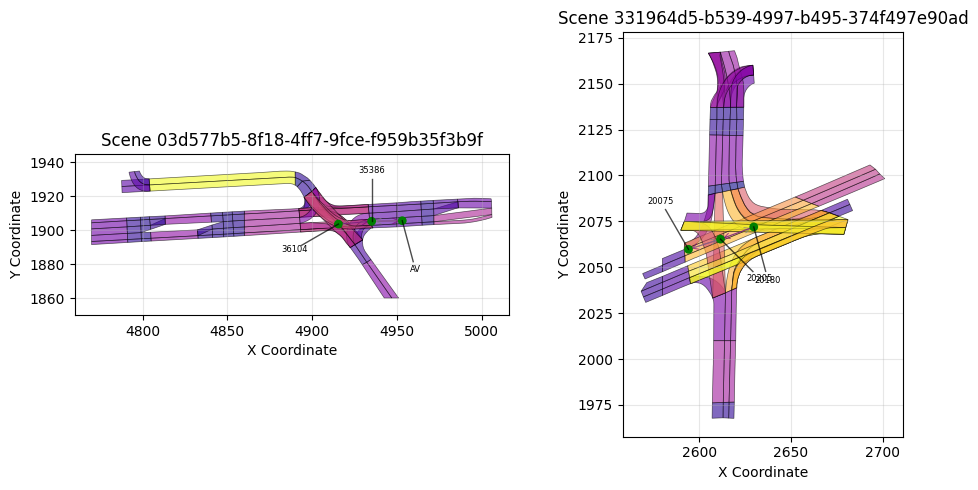

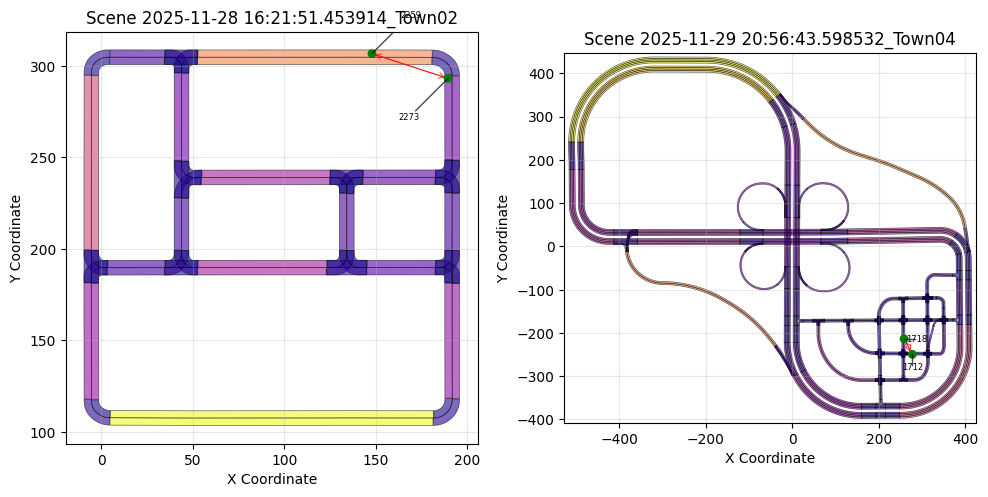

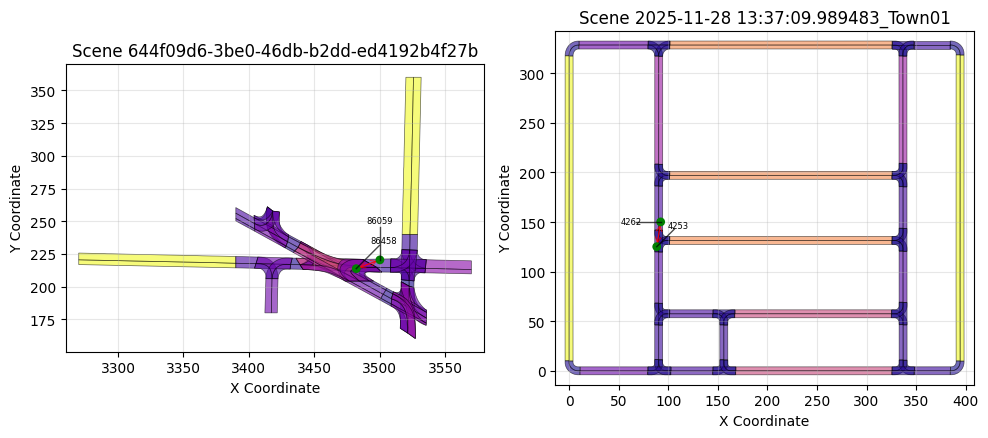

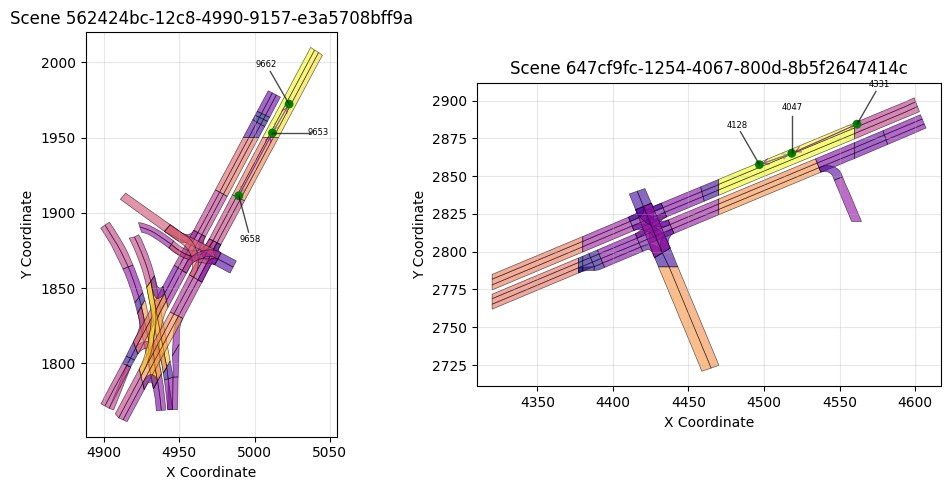

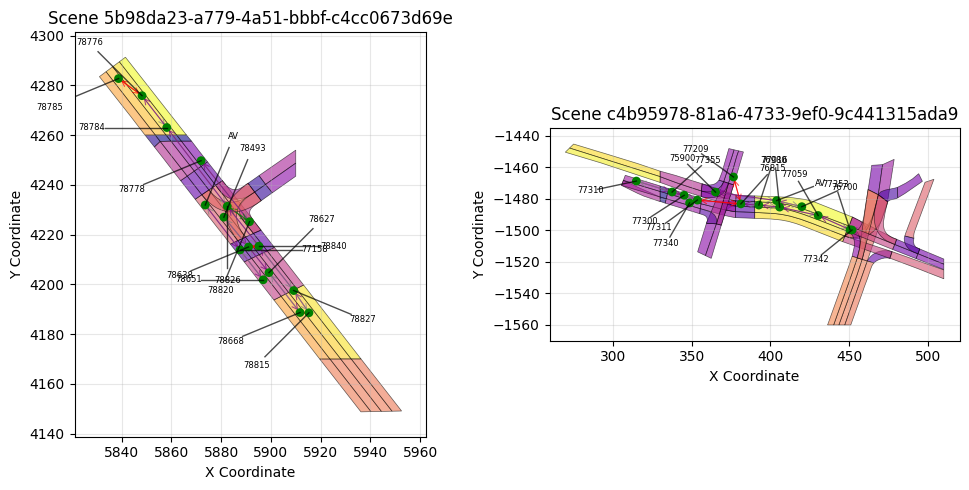

In [45]:
# comparing, no restrictions
for i in range(10):
    try:
        first = dim_reduc_emb_df.sample(1)
        # Use embedding_dim dynamically instead of hardcoded 256
        dim_reduc_emb_df["sq_diff"] = ((dim_reduc_emb_df[list(range(embedding_dim))] - first[list(range(embedding_dim))].values)**2).sum(axis = 1)

        dim_reduc_emb_df.sort_values("sq_diff", inplace=True)

        if first.graph_type.iloc[0] == "carla":
            graph_1 = dim_reduc_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = "_".join(graph_1.split("_")[:2])
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/{carla_graph_dir}_components_nx/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/{carla_graph_dir}/{scn_1}_map_graph.pkl')
            g_map_1 = g_map_1.graph.graph
        else:
            # argoverse option
            graph_1 = dim_reduc_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = graph_1[:36]
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/{argoverse_graph_dir}_components_nx/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/{argoverse_graph_dir}/{scn_1}_map_graph.pkl')
            g_map_1 = g_map_1.graph.graph
        if dim_reduc_emb_df.graph_type.iloc[1] == "carla":
            graph_2 = dim_reduc_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = "_".join(graph_2.split("_")[:2])
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/{carla_graph_dir}_components_nx/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/{carla_graph_dir}/{scn_2}_map_graph.pkl')
            g_map_2 = g_map_2.graph.graph
        else:
            # argoverse option
            graph_2 = dim_reduc_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = graph_2[:36]
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/{argoverse_graph_dir}_components_nx/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/{argoverse_graph_dir}/{scn_2}_map_graph.pkl')
            g_map_2 = g_map_2.graph.graph

        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        MapVisualizer(fig=fig, ax=ax1) \
            .add_lanes(g_map_1, color_by_length=True, cmap='plasma', show_labels=False) \
            .add_actors(nx_graph_1, actor_size=20) \
            .add_actor_labels() \
            .add_actor_edges(nx_graph_1) \
            .set_title(f'Scene {scn_1}')

        MapVisualizer(fig=fig, ax=ax2) \
            .add_lanes(g_map_2, color_by_length=True, cmap='plasma', show_labels=False) \
            .add_actors(nx_graph_2, actor_size=20) \
            .add_actor_labels() \
            .add_actor_edges(nx_graph_2) \
            .set_title(f'Scene {scn_2}')

        plt.tight_layout()
        plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_comparison_plausibility_check_{i}.png")
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")

In [ ]:
# # comparing argo to argo, still needs to be updated to new plotting class

# for i in range(10):
#     first = pca_argo_df.sample(1)
#     pca_argo_df["dist"] = (pca_argo_df.pca1 - first.pca1.iloc[0])**2 + (pca_argo_df.pca2 - first.pca2.iloc[0])**2 
#     pca_argo_df.sort_values("dist", inplace=True)
#     graph_1 = pca_argo_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
#     graph_2 = pca_argo_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
#     scn_1 = graph_1[:36]
#     scn_2 = graph_2[:36]
#     file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_1}.pkl"
#     with open(file_path_1, 'rb') as f:
#         nx_graph_1 = pickle.load(f)
#     file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_2}.pkl"
#     with open(file_path_2, 'rb') as f:
#         nx_graph_2 = pickle.load(f)
#     # Create figure with two subplots side by side
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#     # First scene (left subplot)
#     g_map = MapGraph()
#     g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_1}_map_graph.pkl')
#     fig, ax1 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
#     fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
#     fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
#     ax1.set_title(f'Scene {scn_1}')
#     # Second scene (right subplot)
#     g_map = MapGraph()
#     g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_2}_map_graph.pkl')
#     fig, ax2 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
#     fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
#     fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
#     ax2.set_title(f'Scene {scn_2}')
#     # Adjust layout and display
#     plt.tight_layout()
#     plt.show()


In [ ]:
# # comparing carla to carla, still needs to be updated to new plotting class

# for i in range(10):
#     try:
#         first = pca_carla_df.sample(1)
#         pca_carla_df["dist"] = (pca_carla_df.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
#         pca_carla_df.sort_values("dist", inplace=True)
#         graph_1 = pca_carla_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
#         graph_2 = pca_carla_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
#         scn_1 = "_".join(graph_1.split("_")[:2])
#         scn_2 = "_".join(graph_2.split("_")[:2])
#         print(graph_1, scn_1)
#         print(graph_2, scn_2)
#         pca_df.head(2)
#         file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_1}.pkl"
#         with open(file_path_1, 'rb') as f:
#             nx_graph_1 = pickle.load(f)
#         file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_2}.pkl"
#         with open(file_path_2, 'rb') as f:
#             nx_graph_2 = pickle.load(f)
#         # Create figure with two subplots side by side
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#         # First scene (left subplot)
#         g_map = MapGraph()
#         g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
#         fig, ax1 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
#         fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
#         fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
#         ax1.set_title(f'Scene {scn_1}')
#         # Second scene (right subplot)
#         g_map = MapGraph()
#         g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
#         fig, ax2 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
#         fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
#         fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
#         ax2.set_title(f'Scene {scn_2}')
#         # Adjust layout and display
#         plt.tight_layout()
#         plt.show()
#     except Exception as e:
#         print(f"Error processing scene {scn_1} and {scn_2}: {e}")
